# Bayes project : Dugongs - nonlinear growth curve

Realised by : 

---
- Hadder Oussama 
- Marwane Fahim
- Salimou Moussa
- Achraf Drissi

---



Carlin and Gelfand (1991) present a nonconjugate Bayesian analysis of the following data set from Ratkowsky (1983).The data are length and age measurements for 27 captured dugongs (sea cows). Carlin and
Gelfand (1991) model this data using a nonlinear growth curve with no inflection point and an
asymptote as Xi
tends to infinity: 
$$Y_i \sim \mathcal{N}(\mu_i, \tau) \text{ pour } i = 1, \dots, 27$$

$$\mu_i = \alpha - \beta \gamma^X \text{ avec } \alpha, \beta > 0 \text{ et } 0 < \gamma < 1$$

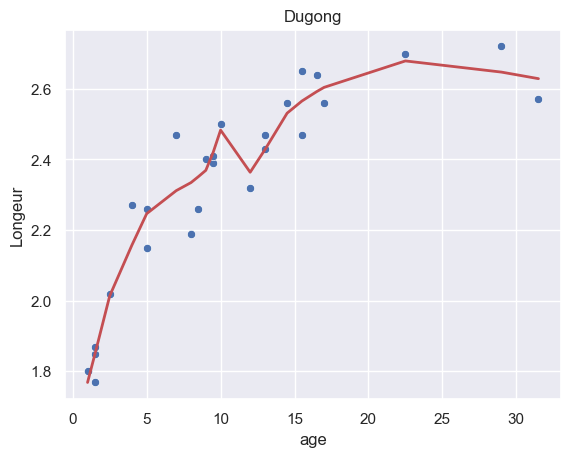

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma, truncnorm, uniform
import statsmodels.api as sm

# Data
X = np.array([1, 1.5, 1.5, 1.5, 2.5, 4, 5, 5, 7, 8, 8.5, 9, 9.5, 9.5, 10,
              12, 12, 13, 13, 14.5, 15.5, 15.5, 16.5, 17, 22.5, 29, 31.5])

Y = np.array([1.8, 1.85, 1.87, 1.77, 2.02, 2.27, 2.15, 2.26, 2.47, 2.19,
              2.26, 2.4, 2.39, 2.41, 2.5, 2.32, 2.32, 2.43, 2.47, 2.56, 2.65,
              2.47, 2.64, 2.56, 2.7, 2.72, 2.57])

data = pd.DataFrame({"X": X, "Y": Y})

lowess = sm.nonparametric.lowess
smoothed_points = lowess(data["Y"], data["X"], frac=0.3)

sns.set_theme()
sns.scatterplot(x="X", y="Y", data=data)
plt.plot(smoothed_points[:, 0], smoothed_points[:, 1], 'r-', lw=2)
plt.title("Dugong")
plt.xlabel("age")
plt.ylabel("Longeur")
plt.show()

The points on the graph represent the actual data for each dugong, and the smoothed red curve illustrates the general trend of dugong growth as a function of their age.

The graph shows that the length of dugongs increases with age, but this increase appears to slow down as the dugongs get older. This nonlinear trend is depicted by the smoothed red curve, which demonstrates a rapid increase in length at first, followed by a slower increase until it reaches a nearly constant value for older dugongs.

In [6]:
def logit(x):
    return np.log(x / (1 - x))

def inv_logit(x):
    return 1 / (1 + np.exp(-x))

## Gibbs Sampling : 
To estimate the random variables listed earlier, we used the Gibbs algorithm, which is a Markov Chain Monte Carlo (MCMC) method of sampling. This algorithm generates samples from the posterior distribution of the parameters given the data.

To ensure the convergence of the algorithm, we used a burn-in phase of 1000 samples. During this phase, the samples generated by the algorithm are discarded and not used to estimate the parameters. This step helps to reduce the influence of the initial conditions on the final results.

In [2]:
def gibbs_sampling(age, Y, nchain=10**4, prop_sd=np.array([0.01, 0.1, 1, 0.01])):
    init = np.array([2, 1, 11, 0.9])
    chain = np.empty((nchain + 1, 4))
    chain[0, :] = init
    n = len(Y)
    sig = 1000

    for iter in range(nchain):
        current = chain[iter, :]

        # Update alpha
        prop = current.copy()
        prop[0] = np.random.lognormal(np.log(current[0]), prop_sd[0])
        kernel_ratio = prop[0] / current[0]

        top = np.sum(norm.logpdf(Y, prop[0] - current[1] * current[3] ** age, 1 / np.sqrt(current[2]))) + \
            norm.logpdf(prop[0], 0, sig)
        bottom = np.sum(norm.logpdf(Y, current[0] - current[1] * current[3] ** age, 1 / np.sqrt(current[2]))) + \
            norm.logpdf(current[0], 0, sig)

        acc_prob = np.exp(top - bottom) * kernel_ratio

        if np.random.uniform() < acc_prob:
            current = prop.copy()

        # Update beta
        prop = current.copy()
        prop[1] = np.random.lognormal(np.log(current[1]), prop_sd[1])
        kernel_ratio = prop[1] / current[1]

        top = np.sum(norm.logpdf(Y, current[0] - prop[1] * current[3] ** age, 1 / np.sqrt(current[2]))) + \
            norm.logpdf(prop[1], 0, sig)
        bottom = np.sum(norm.logpdf(Y, current[0] - current[1] * current[3] ** age, 1 / np.sqrt(current[2]))) + \
            norm.logpdf(current[1], 0, sig)

        acc_prob = np.exp(top - bottom) * kernel_ratio

        if np.random.uniform() < acc_prob:
            current = prop.copy()

        # Update tau
        prop = current.copy()
        prop[2] = np.random.lognormal(np.log(current[2]), prop_sd[2])

        kernel_ratio = prop[2] / current[2]

        top = np.sum(norm.logpdf(Y, current[0] - current[1] * current[3] ** age, 1 / np.sqrt(prop[2]))) + \
            gamma.logpdf(prop[2], a=0.001, scale=1/0.001)
        bottom = np.sum(norm.logpdf(Y, current[0] - current[1] * current[3] ** age, 1 / np.sqrt(current[2]))) + \
            gamma.logpdf(current[2], a=0.001, scale=1/0.001)

        acc_prob = np.exp(top - bottom) * kernel_ratio

        if np.random.uniform() < acc_prob:
            current = prop.copy()

        # Update gamma
        prop = current.copy()
        prop[3] = np.random.lognormal(np.log(current[3]), prop_sd[3])

        kernel_ratio = prop[3] / current[3]
        top = np.sum(norm.logpdf(Y, current[0] - current[1] * prop[3] ** age, 1 / np.sqrt(current[2]))) + \
            uniform.logpdf(prop[3], 0.5, 0.5)
        bottom = np.sum(norm.logpdf(Y, current[0] - current[1] * current[3] ** age, 1 / np.sqrt(current[2]))) + \
            uniform.logpdf(current[3], 0.5, 0.5)

        acc_prob = np.exp(top - bottom) * kernel_ratio

        if np.random.uniform() < acc_prob and prop[3] < 1:
            current = prop.copy()

        # Save the new state
        chain[iter + 1, :] = current

    return chain

## Visualization of the parameters $\alpha , \gamma , \beta , \tau$ : 

Here we are going to plot the Markov Chain of the estimated parameters based on the results given by the Gibbs algorithm using the burn-in implementation.

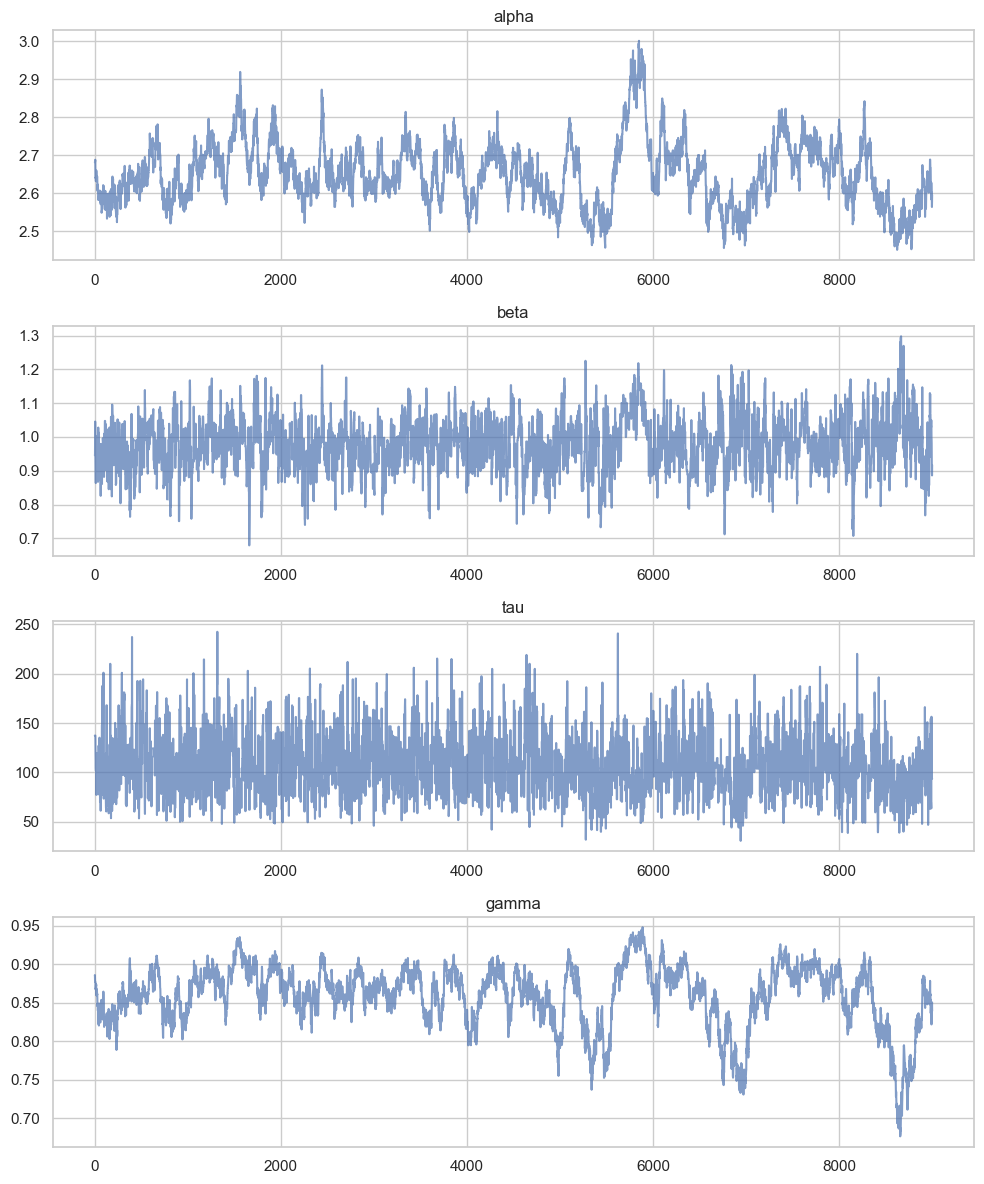

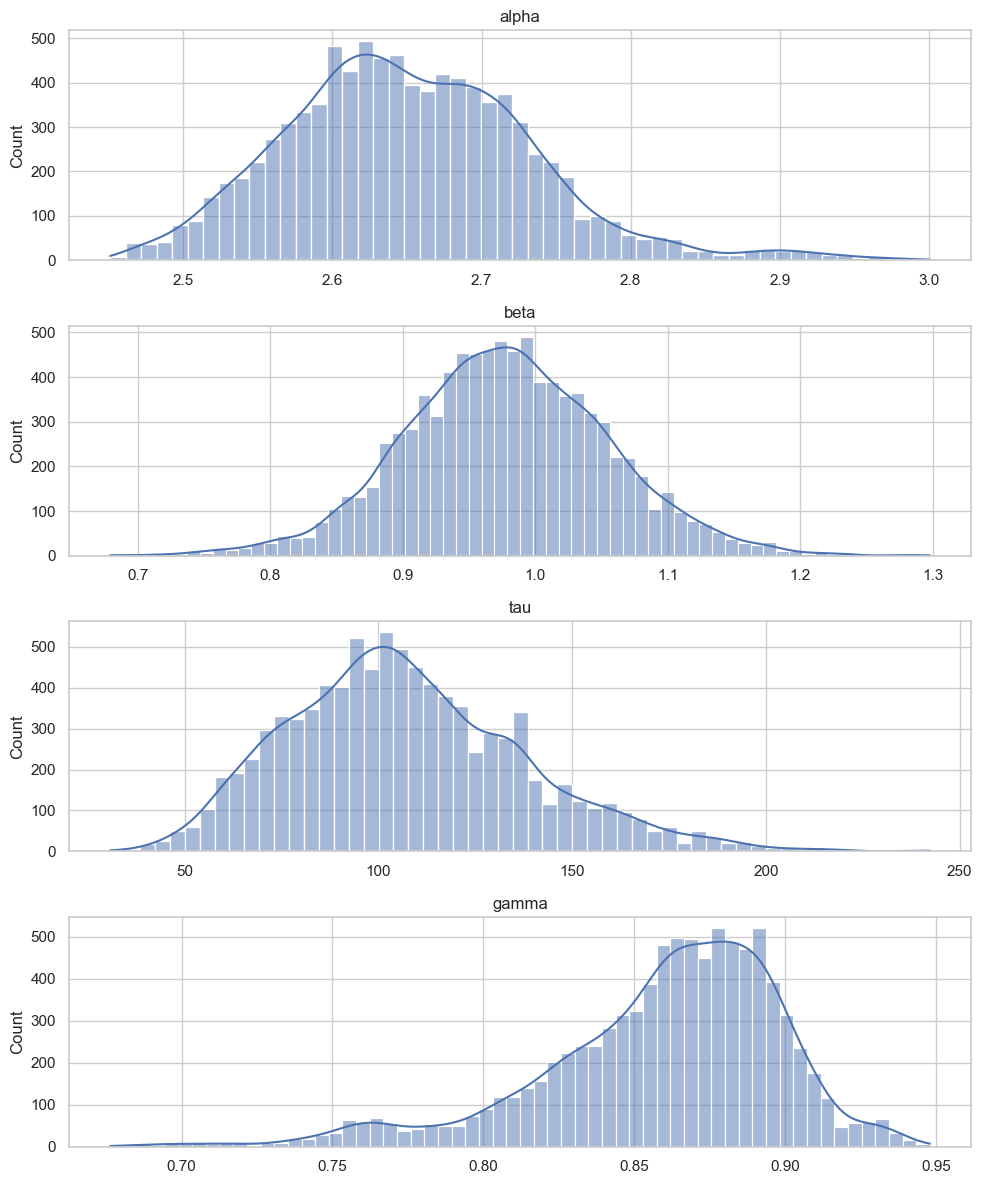

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

nchain = 10000
chain = gibbs_sampling(X, Y, nchain)

# Remove burning period
burn_in = 1000
chain = chain[burn_in:]

# Set the style for the plots
sns.set(style="whitegrid")

param_names = ['alpha', 'beta', 'tau', 'gamma']

def plot_trace(chains, param_names):
    n_params = len(param_names)
    fig, axes = plt.subplots(n_params, 1, figsize=(10, 3 * n_params))

    for idx, ax in enumerate(axes):
        ax.plot(chains[:, idx], alpha=0.7)
        ax.set_title(param_names[idx])

    plt.tight_layout()
    plt.show()

def plot_histograms(chains, param_names):
    n_params = len(param_names)
    fig, axes = plt.subplots(n_params, 1, figsize=(10, 3 * n_params))

    for idx, ax in enumerate(axes):
        sns.histplot(chains[:, idx], kde=True, ax=ax)
        ax.set_title(param_names[idx])

    plt.tight_layout()
    plt.show()

plot_trace(chain, param_names)
plot_histograms(chain, param_names)




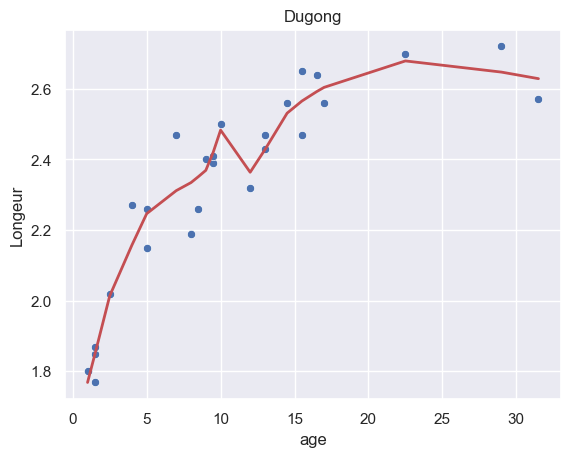

In [8]:
lowess = sm.nonparametric.lowess
smoothed_points = lowess(data["Y"], data["X"], frac=0.3)
sns.set_theme()
sns.scatterplot(x="X", y="Y", data=data)
plt.plot(smoothed_points[:, 0], smoothed_points[:, 1], 'r-', lw=2)
plt.title("Dugong")
plt.xlabel("age")
plt.ylabel("Longeur")
plt.show()

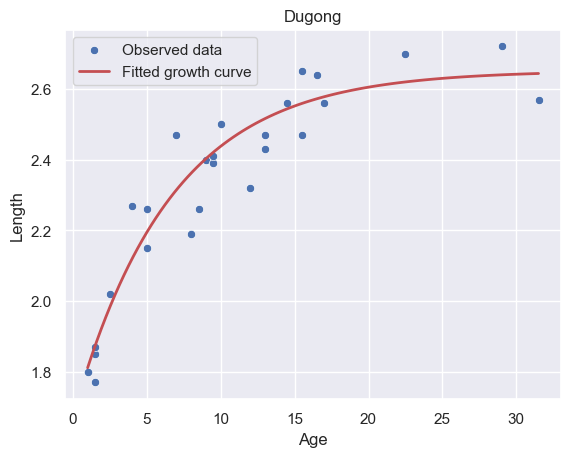

Predicted length for a dugong of age 20: 2.60


In [9]:
# Fitted growth curve
def fitted_growth_curve(age, alpha, beta, gamma):
    return alpha - beta * gamma ** age

# Mean values of the parameters
mean_alpha = np.mean(chain[:, 0])
mean_beta = np.mean(chain[:, 1])
mean_gamma = np.mean(chain[:, 3])


# Plot the observed data and the fitted growth curve
sns.scatterplot(x="X", y="Y", data=data, label="Observed data")
age_range = np.linspace(X.min(), X.max(), 100)
plt.plot(age_range, fitted_growth_curve(age_range, mean_alpha, mean_beta, mean_gamma), 'r-', lw=2, label="Fitted growth curve")
plt.title("Dugong")
plt.xlabel("Age")
plt.ylabel("Length")
plt.legend()
plt.show()

# Predict the length of a new dugong with a given age
new_age = 20
predicted_length = fitted_growth_curve(new_age, mean_alpha, mean_beta, mean_gamma)
print(f"Predicted length for a dugong of age {new_age}: {predicted_length:.2f}")


It displays a graph that shows the relationship between the age and length of dugongs, with observed data points and a fitted growth curve. The fitted growth curve, plotted in red, is based on the mean values of the parameters estimated from the Gibbs algorithm.

The graph illustrates that the fitted growth curve closely follows the observed data points, demonstrating that the model is appropriate for analyzing dugong growth. It also shows the nonlinear nature of the relationship between age and length, with the rate of growth slowing down as the dugongs get older.

Additionally, The predicted length for a 20-year-old dugong is displayed as being 2.6, providing an estimation of the dugong's length based on the fitted growth curve.

        count      mean       std       min       25%       50%       75%  \
alpha  9001.0  2.651705  0.083287  2.451066  2.595199  2.645673  2.704042   
beta   9001.0  0.978081  0.077506  0.679109  0.928125  0.977058  1.028778   
sigma  9001.0  0.099668  0.014793  0.064238  0.089105  0.098082  0.108152   
gamma  9001.0  0.859035  0.040543  0.676354  0.839173  0.866155  0.886993   

            max  
alpha  3.000669  
beta   1.297850  
sigma  0.180144  
gamma  0.948013  


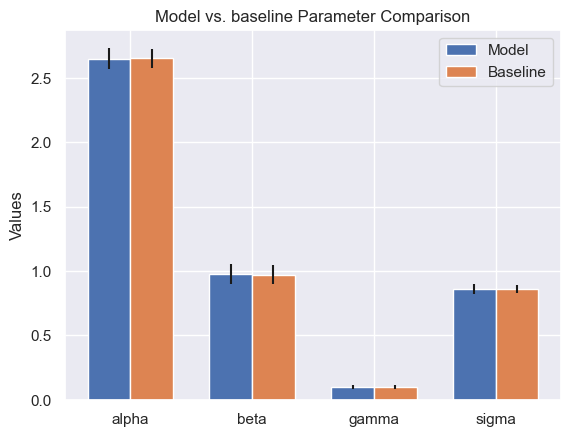

In [32]:
results = pd.DataFrame()
results['alpha']=chain[:, 0]
results['beta']=chain[:, 1]
results['sigma']=1/np.sqrt(chain[:, 2])
results['gamma']=chain[:, 3]

def plot_parameter_comparison(params_df):
    ind = np.arange(len(params_df))  # the x locations for the groups
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind - width / 2, params_df['mean'], width, label='Model', yerr=params_df['std'])
    rects2 = ax.bar(ind + width / 2, params_df['mean_base'], width, label='Baseline', yerr=params_df['std_base'])

    ax.set_ylabel('Values')
    ax.set_title('Model vs. baseline Parameter Comparison')
    ax.set_xticks(ind)
    ax.set_xticklabels(['alpha', 'beta', 'gamma' , 'sigma'])
    ax.legend()

    plt.show()

results_summary = results.describe().T
print(results_summary)

params_df = pd.DataFrame()
params_df['mean'] = results_summary['mean']
params_df['std'] = results_summary['std']
#Carlin and Gelfand estimates
params_df['mean_base'] = [2.652, 0.9729 ,0.0992 ,0.8623  ]
params_df['std_base'] = [0.07094, 0.07649,0.01496, 0.03259]
params_df.reset_index(drop=True, inplace=True)

plot_parameter_comparison(params_df)

By comparing our results with reference values, we can see that our estimates are approaching what was expected. This indicates that our implementation of the Gibbs algorithm is working well and that our model is suitable for analyzing the data in this study.